In [1]:
from pathlib import Path

import numpy as np
from tqdm import tqdm

import idmlaser.kmcurve as kmcurve
import idmlaser.pyramid as pyramid
from idmlaser.models.numpynumba import NumbaSpatialSEIR
from idmlaser.numpynumba import DemographicsByYear
from idmlaser.utils import PriorityQueuePy
from idmlaser.utils import PropertySet

SCRIPT_PATH = Path.cwd().absolute()

NYEARS = 5
meta_params = PropertySet(
    {
        "ticks": 365*NYEARS,
        "nodes": 1,
        "seed": 20240702,
        "output": Path.cwd() / "outputs",
    }
)

model_params = PropertySet(
    {
        "exp_mean": np.float32(7.0),
        "exp_std": np.float32(1.0),
        "inf_mean": np.float32(7.0),
        "inf_std": np.float32(1.0),
        "r_naught": np.float32(14.0),
        "seasonality_factor": np.float32(0.125),
        "seasonality_offset": np.float32(182),
    }
)

params = PropertySet(meta_params, model_params)


In [2]:

model = NumbaSpatialSEIR(params)

# Ignore optional parameters, cbr, mortality, and immigration
demographics = DemographicsByYear(nyears=NYEARS, nnodes=1)
CAPACITY = 1_000_000
demographics.initialize(initial_population=CAPACITY)

max_capacity = CAPACITY
INFECTIONS = 10
initial = np.zeros((1, 4), dtype=np.uint32)
initial[0, :] = [CAPACITY - INFECTIONS, 0, INFECTIONS, 0]  # S, E, I, R
network = np.zeros((1, 1), dtype=np.float32)  # 1x1 network
model.initialize(CAPACITY*2, demographics, initial, network)

Model parameters: {'exp_mean': 7.0, 'exp_std': 1.0, 'inf_mean': 7.0, 'inf_std': 1.0, 'r_naught': 14.0, 'prng_seed': 20240412, 'ticks': 1825, 'nodes': 1, 'seed': 20240702, 'output': PosixPath('/Users/christopherlorton/projects/laser/tests/outputs'), 'seasonality_factor': 0.125, 'seasonality_offset': 182.0, 'beta': 2.0}
Initializing model with 1 nodes: (initial population: 1,000,000 maximum capacity: 2,000,000)


In [3]:
def init_dobs_dods(filename, count, dobs, dods, seed=20240703):
    popdata = pyramid.load_pyramid_csv(filename)
    prng = np.random.default_rng(seed)
    agedist = pyramid.AliasedDistribution(popdata[:, 4], prng=prng)  # ignore sex for now
    indices = agedist.sample(dobs.shape[0])
    minage = popdata[:, 0] * 365  # closed interval (include this value)
    limage = (popdata[:, 1] + 1) * 365  # open interval (do not include this value)
    print("Converting age-bin indices to dates of birth...")
    for i in tqdm(range(len(popdata))):
        mask = indices == i
        dobs[mask] = prng.integers(low=minage[i], high=limage[i], size=mask.sum())
    print("Converting dates of birth to dates of death...")
    for i in tqdm(range(count)):
        dods[i] = kmcurve.predicted_day_of_death(dobs[i])
    dods -= dobs.astype(dods.dtype)  # renormalize to be relative to _now_ (t=0)
    dobs = -dobs  # all _living_ agents have dates of birth before now (t=0)

    return


population = model.population
population.add_property("dod", dtype=np.int32)
init_dobs_dods(
    SCRIPT_PATH / "USA-pyramid-2023.csv", population.count, population.dob, population.dod, seed=params.seed
)  # 2023 is the most recent year of data

# print(f"Pushing {population.dod.shape[0]} agents onto the priority queue...")
print(f"Pushing {population.count} agents onto the priority queue...")
pq = PriorityQueuePy(population.dod.shape[0], population.dod)
dods = population.dod
ticks = params.ticks
# for i in tqdm(range(population.dod.shape[0])):
for i in tqdm(range(population.count)):
    if dods[i] < ticks:
        pq.push(i)

# temp
# print(f"Popping {population.count} agents off the priority queue...")
# for _ in tqdm(range(population.count)):
#     pq.pop()

model.queues = [pq]



Reading data from '/Users/christopherlorton/projects/laser/tests/USA-pyramid-2023.csv' ...
Converting age-bin indices to dates of birth...


100%|██████████| 21/21 [00:00<00:00, 348.22it/s]


Converting dates of birth to dates of death...


100%|██████████| 1000000/1000000 [00:06<00:00, 164278.44it/s]


Pushing 1000000 agents onto the priority queue...


100%|██████████| 1000000/1000000 [00:00<00:00, 1050482.63it/s]


In [4]:
# HACK, HACK, HACK

def non_disease_deaths(model, tick) -> None:
    states = model.population.states
    pq = model.queues[0]  # only one node, right now
    while (pq.size > 0) and (pq.peekv() == tick):
        i = pq.popi()
        states[i] = 0  # dead
    return


model._phases.insert(0, non_disease_deaths)

# KCAH, KCAH, KCAH


## NNMM Required Features

- vital dynamics
  - births
  - non-disease deaths
- maternal protection
- age-based mixing
- seasonality
- routine immunization
- SIAs
- non-uniform shedding

### Vital Dynamics: Births

Just use CBR w/out stochasticity to determine births for each year. We distribute those births uniformly across the year. We put the births into a per-node data structure so the `do_births` phase function can access the per tick birth count.

In [5]:
from idmlaser.models.numpynumba import STATE_SUSCEPTIBLE
from idmlaser.numpynumba import Population

initial_population = CAPACITY
nyears = (params.ticks + 364) // 365
cbr = 18    # crude birth rate per 1000
annual_births = np.zeros(nyears, dtype=np.uint32)
running_population = initial_population
for i in range(nyears):
    annual_births[i] = (cbr * running_population) // 1000
    running_population += annual_births[i]
print(f"Annual births: {annual_births}")
daily_births = np.zeros(params.ticks, dtype=np.uint32)
for i in range(params.ticks):
    iyear = i // 365
    doy = i % 365 + 1  # day of year, 1-based
    daily_births[i] = (annual_births[iyear] * doy // 365) - (annual_births[iyear] * (doy - 1) // 365)

model.nodes = Population(1) # only one node, right now
model.nodes.add_vector_property("births", length=params.ticks, dtype=np.uint32)
model.nodes.births[0,:] = daily_births

def do_births(model, tick) -> None:
    births = model.nodes.births[0][tick]
    if births > 0:
        population = model.population
        istart, iend = population.add(births)
        population.dob[istart:iend] = tick
        population.states[istart:iend] = STATE_SUSCEPTIBLE
        population.susceptibility[istart:iend] = 1
        population.nodeid[istart:iend] = 0

model._phases = list(filter(lambda phase: phase.__name__ != "vital_dynamics", model._phases))   # remove the original vital_dynamics phase
model._phases.insert(0, do_births)  # insert the new do_births phase

print(",".join(phase.__name__ for phase in model._phases))

Annual births: [18000 18324 18653 18989 19331]
do_births,non_disease_deaths,infection_update,incubation_update,transmission_update,report_update


In [6]:
model.run(params.ticks)

# model.report : ticks x channels x nodes
print(model.report.shape)
print(model.report[30:50, :, 0])

print(model.report.sum(axis=1))

100%|██████████| 1825/1825 [00:03<00:00, 521.62it/s]

elapsed time: 0:00:03.500380
(1826, 5, 1)
[[888273  93154  14580   2481   2991]
 [855184 120868  19110   3315   3051]
 [813532 155395  25163   4369   3119]
 [761825 197849  32905   5858   3190]
 [697796 249545  43285   7789   3261]
 [621953 309466  56595  10393   3319]
 [532992 377721  74042  13653   3367]
 [433715 450213  96611  17860   3425]
 [329705 520777 124487  23423   3481]
 [228682 579369 159640  30714   3518]
 [139564 615773 202589  40501   3545]
 [ 71381 619938 254117  53013   3572]
 [ 28713 586667 313454  69638   3599]
 [  7803 519796 379988  90913   3620]
 [  1064 430810 448540 118126   3629]
 [    26 331719 514247 152588   3639]
 [     0 235332 567535 195764   3637]
 [     0 150816 598512 249355   3634]
 [     0  84667 600497 313556   3647]
 [     0  40429 568792 389535   3660]]
[[1000000]
 [1000049]
 [1000098]
 ...
 [1093191]
 [1093244]
 [1093297]]


In [9]:
metrics = model.metrics
columns = metrics.columns[1:]
cumulative = 0
for column in columns:
    total = metrics[column].sum()
    print(f"{column:20}: {total:11,} μs")
    cumulative += total
print("====================================")
print(f"total               : {cumulative:11,} μs")

do_births           :      20,496 μs
non_disease_deaths  :     185,073 μs
infection_update    :     368,697 μs
incubation_update   :     353,376 μs
transmission_update :     954,092 μs
report_update       :   1,581,962 μs
total               :   3,463,696 μs


In [15]:
print("Goodbye [cruel], world!")


Goodbye [cruel], world!


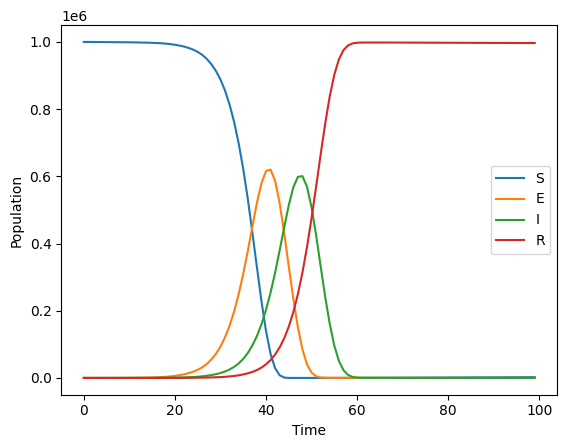

In [10]:
import matplotlib.pyplot as plt

# Extract the "S", "E", "I", and "R" channels from model.report
s_channel = model.report[0:100, 0, 0]
e_channel = model.report[0:100, 1, 0]
i_channel = model.report[0:100, 2, 0]
r_channel = model.report[0:100, 3, 0]

# Plot the channels
plt.plot(s_channel, label="S")
plt.plot(e_channel, label="E")
plt.plot(i_channel, label="I")
plt.plot(r_channel, label="R")

# Add labels and legend
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()

# Show the plot
plt.show()